### Домашняя работа №1. Пономарев Александр

In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import datetime

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

In [2]:
raw_df = pd.read_csv('rosbank_train.csv')
raw_df.head(5)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


In [3]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490513 entries, 0 to 490512
Data columns (total 10 columns):
PERIOD          490513 non-null object
cl_id           490513 non-null int64
MCC             490513 non-null int64
channel_type    487603 non-null object
currency        490513 non-null int64
TRDATETIME      490513 non-null object
amount          490513 non-null float64
trx_category    490513 non-null object
target_flag     490513 non-null int64
target_sum      490513 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 37.4+ MB


In [4]:
print("Total clients: ", len(raw_df.cl_id.unique()))

Total clients:  5000


In [5]:
cl_ids_test = np.random.choice(raw_df.cl_id.unique(), size=1000, replace=False)
cl_ids_test_set = set(cl_ids_test)

# create transactions dataset for train
transactions_train = raw_df[~raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in train dataset: ", len(transactions_train))

# create transactions dataset for test
transactions_test = raw_df[raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in test dataset: ", len(transactions_test))

Total transactions in train dataset:  395427
Total transactions in test dataset:  95086


##### Начнем наш анализ данных с переменной TRDATETIME
Разделим время на следующие группы:
1. Ночное время 00:00 - 06:00 (night_0_6)
2. Утреннее время 06:00 - 12:00 (morning_6_12)
3. Дневное время 12:00 - 18:00 (afternoon_12_18)
4. Вечернее время 18:00 - 00:00 (evening_18_0)

In [44]:
def process_hour(hour):
    hour = int(hour)
    if 6 <= hour < 12:
        return 'morning_6_12'
    elif 12 <= hour < 18:
        return 'afternoon_12_18'
    elif 18 <= hour < 24:
        return 'evening_18_0'
    elif 0 <= hour < 6:
        return 'night_0_6'
    
def group_by_hour(df):
    tr_day_time = df.copy(deep=True)
    tr_day_time['day_time'] = tr_day_time['TRDATETIME']\
        .apply(lambda x: process_hour((datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%H')))
    return tr_day_time.groupby(['cl_id', 'day_time'])['cl_id'].size().unstack().fillna(0).reset_index()


In [45]:
grouped_by_hour = group_by_hour(transactions_train)
grouped_by_hour.head(10)

day_time,cl_id,afternoon_12_18,evening_18_0,morning_6_12,night_0_6
0,0,2.0,0.0,0.0,3.0
1,1,0.0,3.0,0.0,101.0
2,9,9.0,7.0,8.0,15.0
3,10,51.0,1.0,72.0,339.0
4,11,8.0,2.0,0.0,207.0
5,14,2.0,1.0,1.0,132.0
6,20,2.0,0.0,1.0,74.0
7,21,6.0,1.0,1.0,116.0
8,22,2.0,0.0,11.0,46.0
9,23,7.0,6.0,0.0,38.0


In [48]:
grouped_by_hour[['afternoon_12_18', 'evening_18_0', 'morning_6_12', 'night_0_6']].describe()

day_time,afternoon_12_18,evening_18_0,morning_6_12,night_0_6
count,4000.000000,4000.00000,4000.000000,4000.000000
mean,5.129500,2.14875,3.693500,87.885000
std,6.499638,4.23475,5.951211,73.630966
min,0.000000,0.00000,0.000000,0.000000
25%,1.000000,0.00000,0.000000,26.000000
50%,3.000000,0.00000,2.000000,73.000000
75%,7.000000,3.00000,5.000000,132.000000
max,70.000000,65.00000,132.000000,711.000000


In [50]:
grouped_by_hour[['afternoon_12_18', 'evening_18_0', 'morning_6_12', 'night_0_6']].sum()

day_time
afternoon_12_18     20518.0
evening_18_0         8595.0
morning_6_12        14774.0
night_0_6          351540.0
dtype: float64

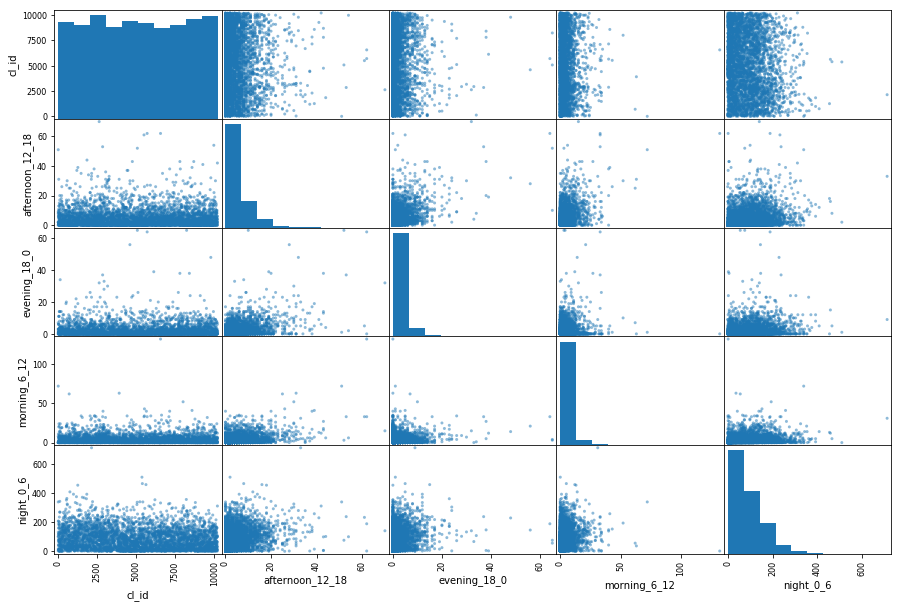

In [46]:
_ = scatter_matrix(
    grouped_by_hour[['cl_id', 'afternoon_12_18', 'evening_18_0', 'morning_6_12', 'night_0_6']], figsize=(15, 10)
)

Как мы можем наблюдать, основное кол-во транзакций приходится на ночное время, однако по данному сету не ясно, в какой временной зоне находятся наши пользователи.

*Далее, разделим время выполнение транзакции по дням недели*

In [51]:
def group_by_hour(df):
    tr_day_time = df.copy(deep=True)
    tr_day_time['day_time'] = tr_day_time['TRDATETIME']\
        .apply(lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%A'))
    return tr_day_time.groupby(['cl_id', 'day_time'])['cl_id'].size().unstack().fillna(0).reset_index()

In [53]:
grouped_by_day = group_by_hour(transactions_train)
grouped_by_day.head(10)

day_time,cl_id,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,0,0.0,0.0,2.0,0.0,1.0,2.0,0.0
1,1,10.0,20.0,15.0,7.0,16.0,20.0,16.0
2,9,4.0,8.0,4.0,5.0,6.0,7.0,5.0
3,10,57.0,35.0,102.0,74.0,65.0,62.0,68.0
4,11,40.0,29.0,25.0,28.0,40.0,30.0,25.0
5,14,39.0,22.0,4.0,14.0,30.0,12.0,15.0
6,20,7.0,10.0,4.0,6.0,22.0,15.0,13.0
7,21,36.0,6.0,13.0,22.0,16.0,13.0,18.0
8,22,11.0,6.0,14.0,15.0,12.0,0.0,1.0
9,23,10.0,8.0,4.0,3.0,6.0,11.0,9.0


In [55]:
grouped_by_day[['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']].sum()

day_time
Friday       63573.0
Monday       53065.0
Saturday     59584.0
Sunday       50155.0
Thursday     57542.0
Tuesday      55465.0
Wednesday    56043.0
dtype: float64

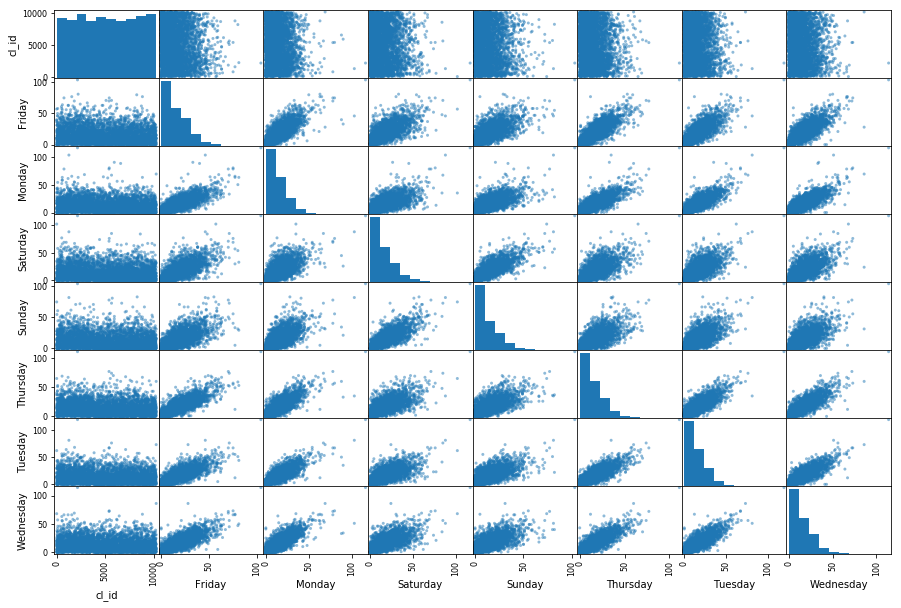

In [59]:
_ = scatter_matrix(
    grouped_by_day[['cl_id', 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']], figsize=(15, 10)
)

Как мы видим, по дням транщакции распределены довольно равномерно.

##### Далее рассмотрим параметр currency

##### Далее рассмотрим параметр channel_type

##### Далее рассмотрим параметр MCC

##### Далее рассмотрим параметр trx_category